# Parameter estimation in PharmaPy

## Learning objectives
After this section, you should be able to:

1. Identify main elements of batch reaction modeling, and construct PharmaPy objects necessary to run a batch reactor model in standalone mode
2. Recognize the importance of sensitivity calculations in dynamic parameter estimation
3. Compare optimization performance with original vs reparametrized reaction kinetics
4. Utilize python data structures and functions along with PharmaPy native objects

## Contextualization

In this notebook, the syntax required to set a unit operation model in PharmaPy and then how to use it to perform parameter estimation will be shown.

The case study shown consists of multiple reactions in a batch reactor:

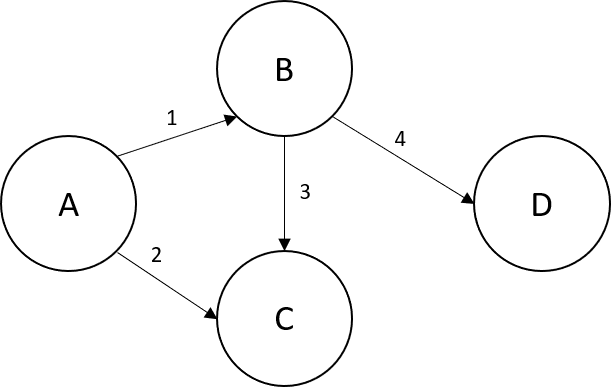

## Reactor model
The batch reactor model solved by PharmaPy for this problem is a system ordinary differential equations (ODEs):

$$ \frac{dC_j}{dt} = \sum_{i=1}^4 \nu_{i, j} r_i \quad \forall j \in \{A, B, C, D\} \label{eq:dC_dt} \tag{2} $$

with reaction rates given by:

$$ r_i = k_i \prod_{k \in \mathcal{R}_i} C_k^{\alpha_{i,k}}, \quad \forall i \in \{1, 2, 3, 4\} \label{eq:rate_eqn} \tag{3} $$

where $\mathcal{R_i}$ is the set of reactants of reaction $i$ (e.g. $\mathcal{R}_3 = \{B\}$). The temperature-dependent coefficient $k_i$ is given by an Arrhenius expression:

$$ k_i = A_i \exp \left[\frac{E_i}{RT} \right], \quad \forall i \in \{1, 2, 3, 4\} \label{eq:ki_temp} \tag{4} $$

In order to simulate a batch reactor in PharmaPy, three objects are required:

1. Reactor: instance containing the unit operation model, Eq. \eqref{eq:dC_dt}
2. Phase object: instance representing the initial liquid load in the reactor
3. Kinetic object: instance that receives reaction rate parameters and calls methods to calculate reaction rates, Eqs. \eqref{eq:rate_eqn}-\eqref{eq:ki_temp}

First, the corresponding PharmaPy classes are called:

In [1]:
from PharmaPy.Phases import LiquidPhase
from PharmaPy.Kinetics import RxnKinetics
from PharmaPy.Reactors import BatchReactor

Could not find GLIMDA.


Then, a liquid phase is specified, which requires the path to a property file that contains pure-component information for all the chemical species (in this case the `json` file pointed by the `path_pure` variable) used in the simulation. Since the pure-component file has 5 species, composition information will be of size 5.

Reaction kinetics receives the path `json` file, and the reaction network, which can be passed as a list of strings. PharmaPy uses this list to construct the stoichiometric matrix of the reaction network. Moreover, some reaction parameter values are provided for reference. Note that $T_{ref}$ in Eq. (4) is not passed to the `RxnKinetics` class, which makes PharmaPy to use infinite as default (non-centered version).

In order to retrieve the documentation of any PharmaPy class or method (i.e. list and description of the mandatory and optional arguments that the class or method takes), use the key combination `Shift` + `Tab`. For instance, to toggle the documentation of the PharmaPy `LiquidPhase` class below, start by writting `LiquidPhase(` and then use the key combination mentioned before.

In [2]:
reactor = BatchReactor()

path_pure = '../data/pure_components_ziegler.json'
liquid = LiquidPhase(path_pure, temp=673, mole_conc=[1, 0, 0, 0, 0], name_solv='solvent')

rxns = ['A --> B', 'A --> C', 'B --> C', 'B --> D']
k_vals = [0.1] * 4
ea_vals = [0] * 4
kin = RxnKinetics(path_pure, rxn_list=rxns, k_params=k_vals, ea_params=ea_vals)

Once phase and kinetic objects are created, they are aggretated to the reactor instance using the dot syntax:

In [3]:
reactor.Phases = liquid
reactor.Kinetics = kin

Now, the reactor model can be solved in standalone mode. The `eval_sens=True` flag will be passed to the solving method in order to compute the sensitivity system of the reaction model. Sensitivity $\mathbf{S}$ indicates at which extent the states of the dynamic system (in this case molar concentrations $C_j$) depend on the parameters ($\theta_p$).

$$ \begin{equation}
    \mathbf{S}(t) \equiv \frac{dC_j}{d\theta_p} \in \mathbb{R}^{n_{comp} \times n_{param}}
   \end{equation}
$$

Sensitivities $\mathbf{S}$ are internally passed to the parameter estimation framework of PharmaPy to guide the parameter search. To understand this, let's recall the objective function of the parameter estimation problem:

$$\begin{equation}
    \min_{\theta} WSSE = (\mathbf{y} - \mathbf{y}_{model})^T W_y^{-1} (\mathbf{y} - \mathbf{y}_{model})
  \end{equation}
$$

The required gradient to guide the optimizer search is:

$$\begin{equation}
    \nabla_{\theta_p} = \frac{dWSSE}{d\theta_p}
   \end{equation}
$$

which is calculated using $\mathbf{S}(t)$.

The sensitivty system is solved along the original ODE system describing the batch reactor. For completeness, a convenience plot function `plot_profiles` allows to check representative results from the model.

In [4]:
time, states, sens = reactor.solve_unit(runtime=120, eval_sens=True)  # run for 2 minutes

Final Run Statistics: --- 

 Number of steps                                    : 99
 Number of function evaluations                     : 124
 Number of Jacobian evaluations                     : 2
 Number of function eval. due to Jacobian eval.     : 0
 Number of error test failures                      : 1
 Number of nonlinear iterations                     : 121
 Number of nonlinear convergence failures           : 0
 Number of sensitivity evaluations                  : 124
 Number of function eval. due to sensitivity eval.  : 0
 Number of sensitivity error test failures          : 0

Sensitivity options:

 Method                   : SIMULTANEOUS
 Difference quotient type : CENTERED
 Suppress Sens            : False

Solver options:

 Solver                   : CVode
 Linear multistep method  : BDF
 Nonlinear solver         : Newton
 Linear solver type       : DENSE
 Maximal order            : 5
 Tolerances (absolute)    : 1e-06
 Tolerances (relative)    : 1e-06

Simulation interva

(<Figure size 1200x300 with 4 Axes>,
 array([<AxesSubplot: ylabel='$C_{j}$ ($\\mathregular{mol \\ L^{-1}}$)'>,
        <AxesSubplot: ylabel='$T$ ($\\mathregular{K}$)'>,
        <AxesSubplot: ylabel='$Q_{rxn}$ ($\\mathregular{W}$)'>],
       dtype=object))

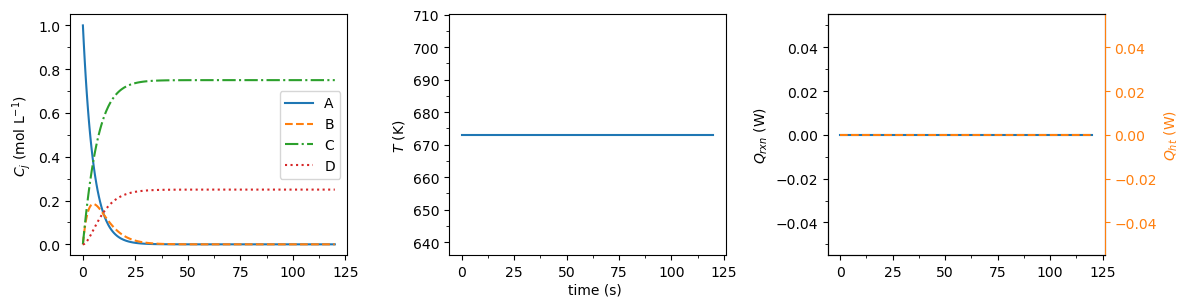

In [5]:
reactor.plot_profiles(figsize=(12, 3))

The sensitivity system can also be plotted as

(<Figure size 600x857.143 with 8 Axes>,
 array([[<AxesSubplot: xlabel='time (s)', ylabel='$\\dfrac{\\partial C_i}{\\partial k_1}$'>,
         <AxesSubplot: xlabel='time (s)', ylabel='$\\dfrac{\\partial C_i}{\\partial k_2}$'>],
        [<AxesSubplot: xlabel='time (s)', ylabel='$\\dfrac{\\partial C_i}{\\partial k_3}$'>,
         <AxesSubplot: xlabel='time (s)', ylabel='$\\dfrac{\\partial C_i}{\\partial k_4}$'>],
        [<AxesSubplot: xlabel='time (s)', ylabel='$\\dfrac{\\partial C_i}{\\partial E_{a, 1}}$'>,
         <AxesSubplot: xlabel='time (s)', ylabel='$\\dfrac{\\partial C_i}{\\partial E_{a, 2}}$'>],
        [<AxesSubplot: xlabel='time (s)', ylabel='$\\dfrac{\\partial C_i}{\\partial E_{a, 3}}$'>,
         <AxesSubplot: xlabel='time (s)', ylabel='$\\dfrac{\\partial C_i}{\\partial E_{a, 4}}$'>]],
       dtype=object))

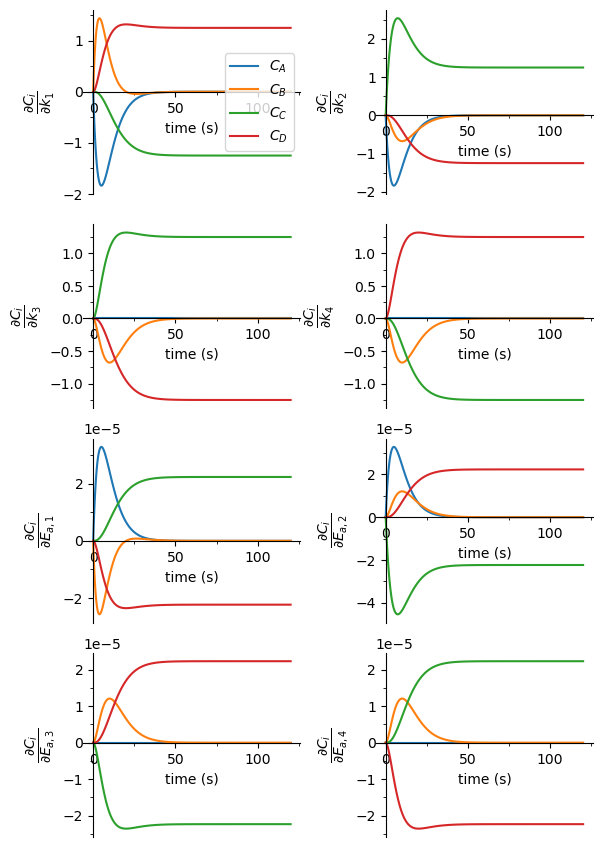

In [6]:
reactor.plot_sens()

Available results can be inspected by printing the `results` instance of the reactor object. Also, its attributes can be used in further calculations as any python object.

In [7]:
print(reactor.result)

------------------------
PharmaPy result object
------------------------

Fields shown in the tables below can be accessed as result.<field>, e.g. result.mole_conc 

---------------------------------------
states      dim   units     index         
---------------------------------------
mole_conc   4     mol/L     A, B, C, D    
---------------------------------------

------------------------------
f(states)   dim   units   index  
------------------------------
q_rxn       1     W              
q_ht        1     W              
temp        1     K              
------------------------------

Time vector can be accessed as result.time



## Parameter estimation procedure
The ultimate goal is to determine the reaction parameters $A_i$ and $E_i$ ($i = [1, 2, 3, 4]$) for each one of the reactions. For this purpose, time-dependent $B$ and $C$ concentration datasets are available at different temperatures.

The approach shown in this notebook has two stages. In the first stage, parameter estimates are found for each isothermal dataset on an individual basis. Then, these parameter estimates are used as seed values in the second stage, where the all the datasets are used simultaneously to obtain representative parameter estimates and confidence intervals.

### First stage: Isothermal fitting
Individual parameter estimation procedures are performed on each isothermal concentration dataset. Each estimation will yield estimates of $A_i$ (or $log(A_i)$) for all reactions at a given temperature. For this reason,  the non-linear regression in PharmaPy will not yield $E_i$ estimates in this first stage. After $k_i$ values are individually obtained by non-linear optimization, estimates of $E_i$ are calculated by linear regression.

An additional feature of PharmaPy will be used for parameter estimation in batch reactors. A reformulation of the temperature-dependent term in the kinetic model (Eq. 3) is available in PharmaPy, and can be activated by passing the keyword argument `reformulate_kin=True` to the `RxnKinetics` class. The reformulation has the form:

$$ \ln(k_i) = \varphi_{1, i} + \exp(\varphi_{2, i}) \cdot \left( \frac{1}{T_{mean}} - \frac{1}{T} \right) \quad \forall i \in \{1, 2, 3, 4 \}$$

with the reformulated parameters:

$$ \begin{align*}
    \varphi_{1, i} &= \ln(A_i) - \frac{E_i}{R T_{mean}} \\
    \varphi_{2, i} &= \ln \left( \frac{E_i}{R} \right)
    \end{align*}
$$

Under this reparametrization, the new parameter set is $\theta_p = \{\varphi_{1, 1}, \cdots, \varphi_{1, 4}, \varphi_{2, 1}, \cdots \varphi_{2, 4} \}$. This reformulation brings the estimated parameters and corresponding sensitivities to a closer order of magnitude compared to their original values, making the solution of the parameter estimation problem more numerically stable.

As a sanity check, one dataset from the available data can be plotted:

(14,) (14, 2)


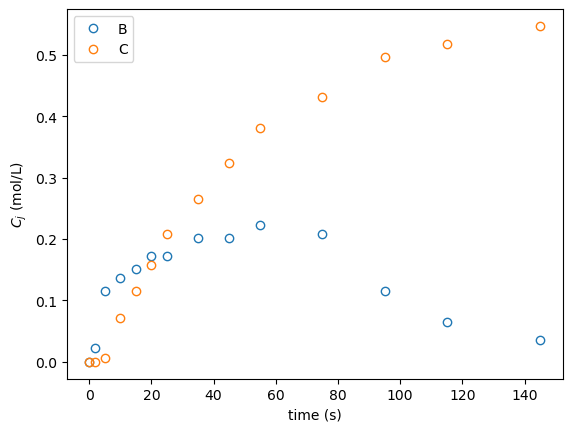

In [8]:
import numpy as np
import matplotlib.pyplot as plt

# Let's import one of the datasets
data = np.genfromtxt('../data/ziegler_data_673K.csv', delimiter=',')
t_exp = data[:, 0]
c_exp = data[:, 1:]

print(t_exp.shape, c_exp.shape)

plt.plot(t_exp, c_exp, 'o', mfc='None')
plt.xlabel('time (s)')
plt.ylabel('$C_j$ (mol/L)')
plt.legend(('B', 'C'))

In order to allow parameter estimation, a simulation object needs to be created. Then, a fully-specified reactor object is aggregated to it, which enables optimization. Because simulation objects can contain one or more unit operations, the connectivity of the flowsheet has to be passed as a string through the `flowsheet` argument.

In [9]:
from PharmaPy.SimExec import SimulationExec
import numpy as np
import copy
import json

# Initial concentration
with open('../data/ziegler_conc_init.json') as f:
    c_init = json.load(f)

sim = SimulationExec(path_pure, flowsheet='R01')

reactor = BatchReactor()

kin = RxnKinetics(path_pure, rxn_list=rxns, k_params=k_vals, ea_params=ea_vals, temp_ref=723, reformulate_kin=True)
kin_seed = copy.deepcopy(kin)
liquid = LiquidPhase(path_pure, mole_conc=c_init['673K'], name_solv='solvent')

reactor.Kinetics = kin
reactor.Phases = liquid

sim.R01 = reactor  # The aggregated instance has to have the same name as the names passed to `sim` through the 'flowsheet' argument

param_bools = [True] * 4 + [False] * 4  # (only k_i's are estimated)
sim.SetParamEstimation(x_data=t_exp, y_data=c_exp, measured_ind=(1, 2), optimize_flags=param_bools)

k_estimated, covar, info_di = sim.EstimateParams()

print(sim.ParamInst.paramest_df)

------------------------------------------------------------
eval    fun_val    ||step||   gradient   dampening_factor
------------------------------------------------------------
0       2.405e+00  ---        1.191e+00  3.529e-03 
1       4.506e-01  2.874e+00  3.891e-01  1.246e-03 
2       2.045e-02  2.825e+00  4.999e-02  4.154e-04 
3       9.994e-03  2.770e-01  3.622e-03  1.385e-04 
4       9.900e-03  4.018e-02  1.204e-04  4.615e-05 
5       9.900e-03  2.421e-03  2.199e-06  1.538e-05 
6       9.900e-03  6.168e-05  5.942e-08  5.128e-06 
7       9.900e-03  2.158e-06  5.942e-08  1.026e-05 
8       9.900e-03  2.157e-06  5.942e-08  4.103e-05 
9       9.900e-03  2.152e-06  5.942e-08  3.282e-04 
10      9.900e-03  2.105e-06  5.942e-08  5.251e-03 
11      9.900e-03  1.563e-06  5.942e-08  1.680e-01 
12      9.900e-03  2.604e-07  5.942e-08  1.075e+01 
------------------------------------------------------------

Optimization time: 1.80e-01 s.
     obj_fun  \varphi_{1, 1}  \varphi_{1, 2}  \varp

Data vs model prediction can be plotted to visually inspect the quality of the fit. Additionally, the prediction of the model with the seed parameters can also be included for completeness. Note that the sensitivities are now with respect to the reparametrized kinetics ($\varphi_{1,i}$ and $\varphi_{2,i}$)

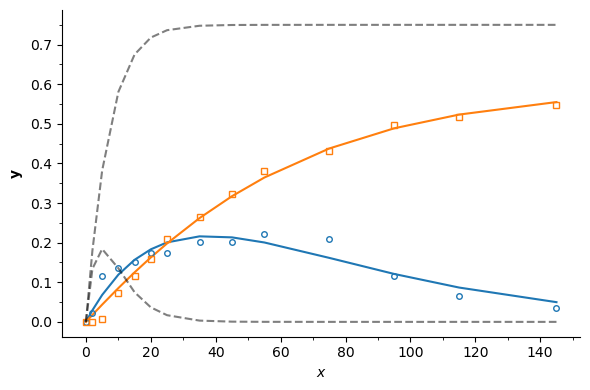

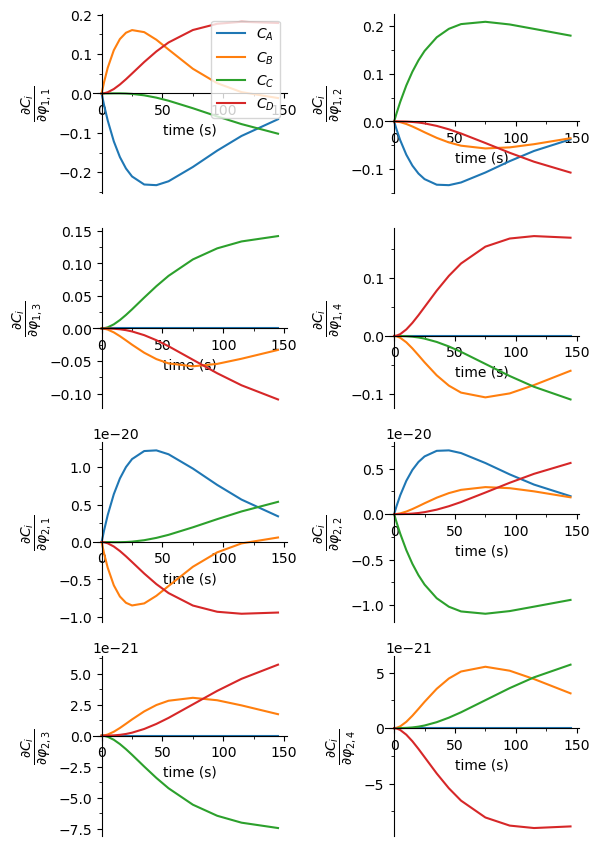

In [10]:
fig, axis = sim.ParamInst.plot_data_model(figsize=(6, 4))

reactor.plot_sens()

# Simulate the system with the parameter seeds and plot
reactor.reset()
reactor.Kinetics = kin_seed

reactor.solve_unit(time_grid=t_exp, verbose=False)
axis.plot(reactor.result.time, reactor.result.mole_conc[:, [1, 2]], 'k--', alpha=0.5)

Now, let's calculate the parameters for all the available datasets, one at a time. The available datasets can be seen under `../data/ziegler_data_XK` where X is the temperature in K. We will use string contatenation syntax `'name_%i' % val`, where val is inserted in the string, being val of the integer datatype (e.g. if `val = 300`, then the string concatenation above will yield `'name_300'`.

------------------------------------------------------------
eval    fun_val    ||step||   gradient   dampening_factor
------------------------------------------------------------
0       2.405e+00  ---        1.191e+00  3.529e-03 
1       4.506e-01  2.874e+00  3.891e-01  1.246e-03 
2       2.045e-02  2.825e+00  4.999e-02  4.154e-04 
3       9.994e-03  2.770e-01  3.622e-03  1.385e-04 
4       9.900e-03  4.018e-02  1.204e-04  4.615e-05 
5       9.900e-03  2.421e-03  2.199e-06  1.538e-05 
6       9.900e-03  6.168e-05  5.942e-08  5.128e-06 
7       9.900e-03  2.158e-06  5.942e-08  1.026e-05 
8       9.900e-03  2.157e-06  5.942e-08  4.103e-05 
9       9.900e-03  2.152e-06  5.942e-08  3.282e-04 
10      9.900e-03  2.105e-06  5.942e-08  5.251e-03 
11      9.900e-03  1.563e-06  5.942e-08  1.680e-01 
12      9.900e-03  2.604e-07  5.942e-08  1.075e+01 
------------------------------------------------------------

Optimization time: 1.73e-01 s.
---------------------------------------------------

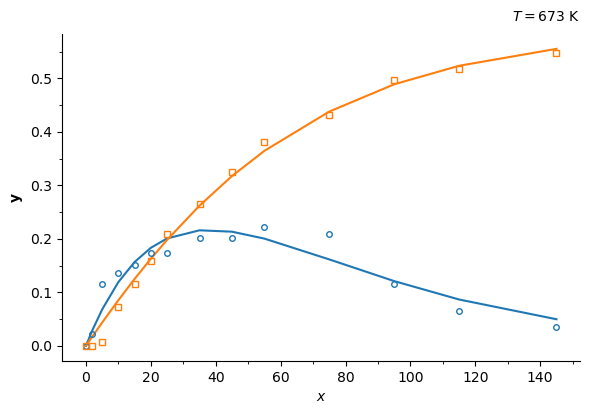

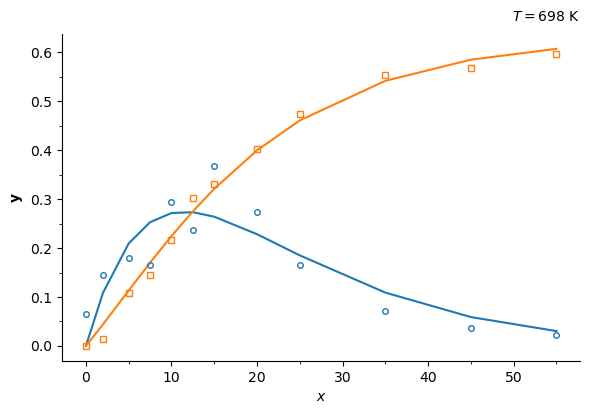

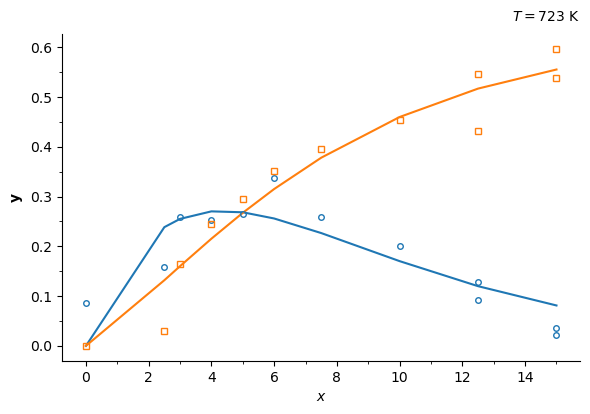

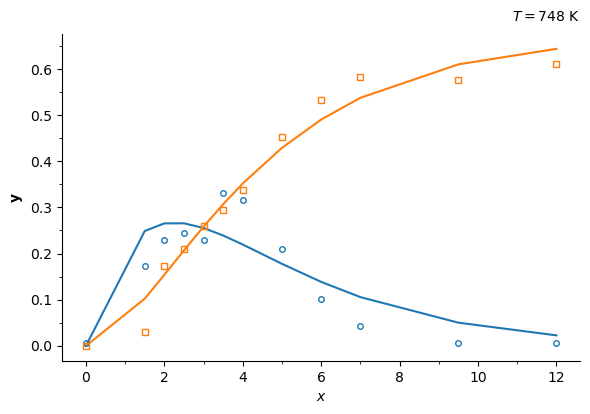

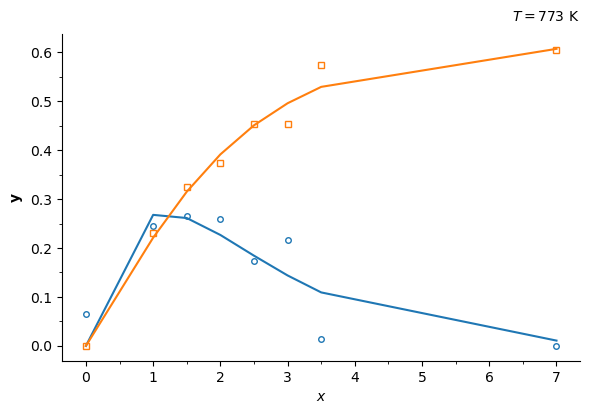

In [11]:
temps = np.array([673, 698, 723, 748, 773])  # available temperatures

lnA_estimated = {}
param_bools = [True] * 4 + [False] * 4  # (only k_i's are estimated)

plot = True
for ind, temp in enumerate(temps):
    data = np.genfromtxt('../data/ziegler_data_%iK.csv' % temp, delimiter=',')
    t_exp = data[:, 0]
    c_exp = data[:, 1:]
    
    sim = SimulationExec(path_pure, flowsheet='R01')

    reactor = BatchReactor()
    kin = RxnKinetics(path_pure, rxn_list=rxns, k_params=k_vals, ea_params=ea_vals, reformulate_kin=True)
    liquid = LiquidPhase(path_pure, temp=temp, mole_conc=[1, 0, 0, 0, 0], name_solv='solvent')

    reactor.Kinetics = kin
    reactor.Phases = liquid

    sim.R01 = reactor

    sim.SetParamEstimation(x_data=t_exp, y_data=c_exp, measured_ind=(1, 2), optimize_flags=param_bools)

    lnA_estim, covar, info_di = sim.EstimateParams()
    lnA_estimated[temp] = lnA_estim
    
    if plot:
        fig, axis = sim.ParamInst.plot_data_model(figsize=(6, 4))
        axis.text(1, 1.04, '$T = %i$ K' % temp, transform=axis.transAxes, fontsize=10, ha='right')

The collected parameters in the dictionary `k_estimated` can be conveniently stacked in a pandas dataframe:

In [12]:
import pandas as pd

param_summary = pd.DataFrame.from_dict(lnA_estimated, orient='index', columns=sim.ParamInst.name_params[:4])    
print(param_summary)

     \varphi_{1, 1}  \varphi_{1, 2}  \varphi_{1, 3}  \varphi_{1, 4}
673       -4.165415       -4.724127       -4.597343       -4.001569
698       -2.739370       -3.852349       -3.117100       -3.141693
723       -1.773407       -3.134609       -2.036008       -2.145335
748       -1.118855       -4.518830       -0.974391       -1.634199
773       -0.457933       -1.542751       -0.862445       -0.796216


Note that, since we passed the `reformulate_model=True` flag to the kinetics class, the data collected in the `param_summary` variable are $\ln(k_i)$ at the given temperatues. A linearized version of Eq. (4) can be written:

$$ \ln(k_i) = \ln(A_i) - \frac{E_i}{R} \left( \frac{1}{T} \right)$$

which allows to find pre-exponential factors $A_i$ and activation energies $E_i$ estimates by performing linear regression of $\ln(k_i)$ vs $1/T$ data. We can do so in a foor loop again. Plots of the data vs the linear model can be generated to visually inspect the goodness of fit for stage one

Text(0.5, 0, '$1000/T$')

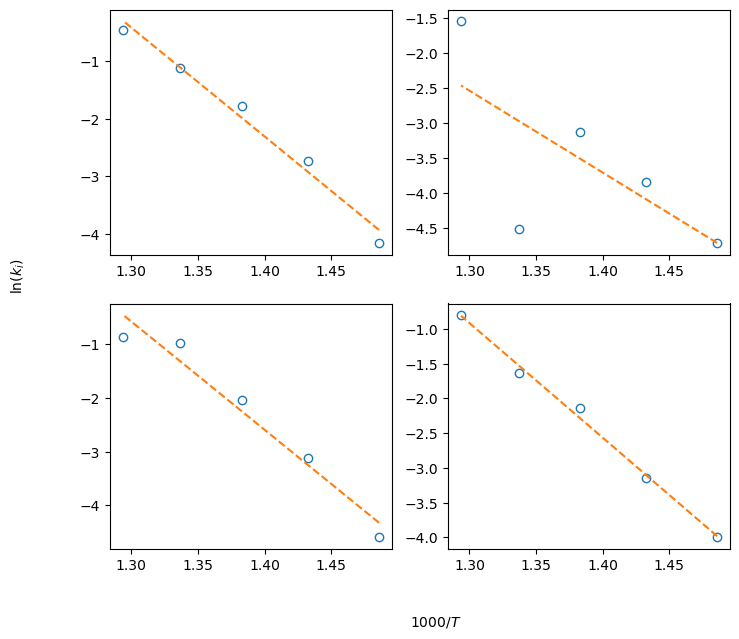

In [13]:
from scipy.stats import linregress

def linear_model(x, sl, interc): return sl * x + interc

ln_A = []
Ea_R = []

fig_lin, ax_lin = plt.subplots(2, 2, figsize=(8, 7))
ax_flat = ax_lin.flatten()
for ind, col in enumerate(param_summary.values.T):
    # Perform linear regression
    x = 1 / temps
    y = col
    res = linregress(x, y)  #

    ln_A.append(res.intercept)
    Ea_R.append(-res.slope)
    
    # Plot
    ax = ax_flat[ind]
    ax.plot(1000*x, y, 'o', mfc='None')  # Data
    
    model = linear_model(x, res.slope, res.intercept)
    ax.plot(1000*x, model, '--')
    
fig_lin.text(0, 0.5, '$\ln(k_i)$', rotation=90, va='center')
fig_lin.text(0.5, 0, '$1000/T$')
    

The final results can be collected into a pandas dataframe:

In [14]:
seed_linear = pd.DataFrame({'ln_A': ln_A, 'Ea/R': Ea_R}, index=rxns)
print(seed_linear)

              ln_A          Ea/R
A --> B  24.177763  18917.969625
A --> C  12.672033  11703.706227
B --> C  25.661558  20180.373959
B --> D  20.532433  16499.900820


## Second stage: Simultaneous estimation

For this purpose, all datasets will be passed at once to the `SetParameterEstimation` method, instead of one at a time. Datasets will be collected into dictionaries first. 

In [15]:
x_data = {}
y_data = {}

phase_modif = {}

for ind, temp in enumerate(temps):
    # Data
    data = np.genfromtxt('../data/ziegler_data_%iK.csv' % temp, delimiter=',')
    t_exp = data[:, 0]
    c_exp = data[:, 1:]

    exp_name = '%.0fK' % temp

    x_data[exp_name] = t_exp
    y_data[exp_name] = c_exp

    phase_modif[exp_name] = {'temp': temp, 'mole_conc': c_init['%iK' % temp]}

Then, new PharmaPy objects (reactor, kinetics and phase) can be created. The parameters found by linear regression in the first stage will be used as seeds for the parameter estimation instance. The keyword argument `reformulate_kin=True` will be also passed for simultaneous parameter estimation.

In [16]:
k_seed = np.exp(seed_linear['ln_A'].values)
ea_seed = 8.314 * seed_linear['Ea/R'].values

## Uncomment the following two lines and evaluate optimization performance
# k_seed = [1e5] * 4
# ea_seed = [1e5] * 4

temp_mean = np.mean(temps)

reformulate = True  # Try with False and compare optimizer performance and parameter estimates
if not reformulate:
    temp_mean = None
    
kin_rxn = RxnKinetics(path_pure, rxn_list=rxns, k_params=k_seed, ea_params=ea_seed,
                      reformulate_kin=reformulate, temp_ref=temp_mean)

liquid = LiquidPhase(path_pure, **phase_modif['698K'], name_solv='solvent')

sim = SimulationExec(path_pure, 'R01')
sim.R01 = BatchReactor()
sim.R01.Kinetics = kin_rxn
sim.R01.Phases = liquid

Parameter estimation is called again, this time with data structures that contain all the datasets simulataneously. After solving the problem, a `ParamInst` object within the `sim` instance is available, which enables more functionalities

------------------------------------------------------------
eval    fun_val    ||step||   gradient   dampening_factor
------------------------------------------------------------
0       2.639e-01  ---        2.370e-01  2.489e-02 
1       2.223e-01  4.831e-01  1.236e-01  2.259e-02 
2       2.172e-01  1.610e-01  3.469e-02  2.237e-02 
3       2.166e-01  1.623e-01  3.012e-02  3.026e-02 
4       2.169e-01  1.473e-01  3.012e-02  6.052e-02 
5       2.159e-01  1.076e-01  2.053e-02  7.166e-02 
6       2.155e-01  5.188e-02  6.129e-03  7.166e-02 
7       2.155e-01  2.046e-02  2.628e-03  7.203e-02 
8       2.155e-01  8.979e-03  1.084e-03  7.218e-02 
9       2.155e-01  3.927e-03  4.597e-04  7.241e-02 
10      2.155e-01  1.627e-03  1.978e-04  7.241e-02 
11      2.155e-01  8.082e-04  8.506e-05  7.241e-02 
12      2.155e-01  3.515e-04  3.896e-05  7.026e-02 
13      2.155e-01  2.192e-04  1.887e-05  6.600e-02 
14      2.155e-01  1.191e-04  1.030e-05  3.647e-02 
15      2.155e-01  1.164e-04  6.681e-06 

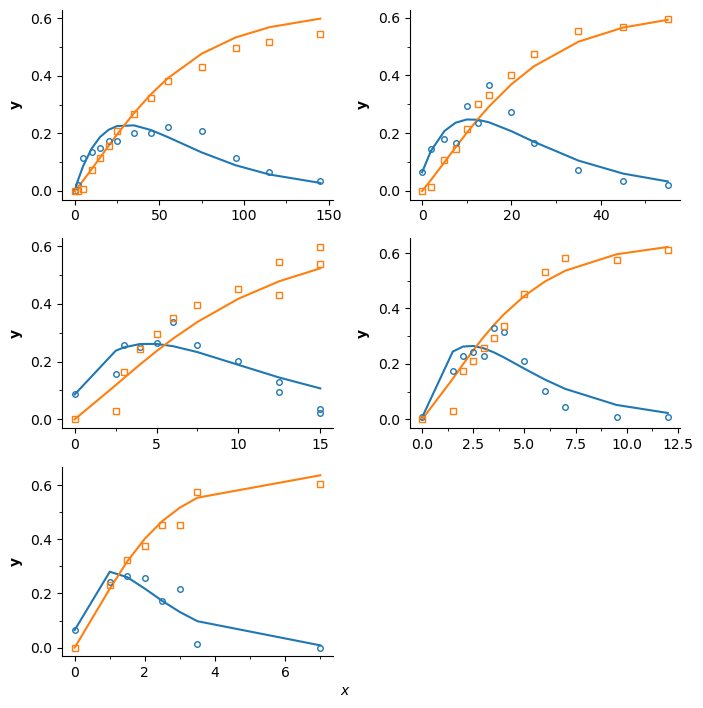

In [17]:
sim.SetParamEstimation(x_data=x_data, y_data=y_data, measured_ind=(1, 2), phase_modifiers=phase_modif)

optimopts = {'eps_1': 1e-11, 'eps_2': 1e-11}

optim_params, hessian_inv, info = sim.EstimateParams(optim_options=optimopts)

fig, axis = sim.ParamInst.plot_data_model(figsize=(7, 7))

Different statistics such as confidence intervals can be generated by creating a statistics instance from the simulation object:

In [18]:
stats = sim.CreateStatsObject(alpha=0.95)
intervals = stats.get_intervals()


----------------------------------------------------------------------------------------------------
param              lb             mean             ub         95% CI (+/-)   95% CI (+/- %) 
----------------------------------------------------------------------------------------------------
\varphi_{1, 1}   -2.177e+00      -2.022e+00      -1.867e+00       1.549e-01        7.66361    
\varphi_{1, 2}   -3.754e+00      -3.332e+00      -2.909e+00       4.228e-01       12.69212    
\varphi_{1, 3}   -2.401e+00      -2.152e+00      -1.903e+00       2.490e-01       11.56767    
\varphi_{1, 4}   -2.445e+00      -2.301e+00      -2.158e+00       1.437e-01        6.24629    
\varphi_{2, 1}    9.690e+00       9.807e+00       9.924e+00       1.170e-01        1.19322    
\varphi_{2, 2}    9.375e+00       9.688e+00       1.000e+01       3.125e-01        3.22595    
\varphi_{2, 3}    9.591e+00       9.770e+00       9.948e+00       1.781e-01        1.82350    
\varphi_{2, 4}    9.552e+00       9.683

Now let's run some of the models at the optimum parameter values and check the sensitivity system

In [19]:
if reformulate:
    ea_optim = np.exp(optim_params[4:]) * 8.314
    k_optim = np.exp(ea_optim/8.314/temp_mean + optim_params[:4])
else:
    k_optim = optim_params[:4]
    ea_optim = optim_params[4:]
                     
kin_rxn = RxnKinetics(path_pure, rxn_list=rxns, k_params=k_optim, ea_params=ea_optim,
                      reformulate_kin=reformulate, temp_ref=temp_mean)

temp_str = '698K'
liquid = LiquidPhase(path_pure, **phase_modif[temp_str], name_solv='solvent')

reactor = BatchReactor()
reactor.Kinetics = kin_rxn
reactor.Phases = liquid

time, states, sens = reactor.solve_unit(runtime=x_data[temp_str][-1], eval_sens=True)

Final Run Statistics: --- 

 Number of steps                                    : 76
 Number of function evaluations                     : 104
 Number of Jacobian evaluations                     : 2
 Number of function eval. due to Jacobian eval.     : 0
 Number of error test failures                      : 4
 Number of nonlinear iterations                     : 101
 Number of nonlinear convergence failures           : 0
 Number of sensitivity evaluations                  : 104
 Number of function eval. due to sensitivity eval.  : 0
 Number of sensitivity error test failures          : 0

Sensitivity options:

 Method                   : SIMULTANEOUS
 Difference quotient type : CENTERED
 Suppress Sens            : False

Solver options:

 Solver                   : CVode
 Linear multistep method  : BDF
 Nonlinear solver         : Newton
 Linear solver type       : DENSE
 Maximal order            : 5
 Tolerances (absolute)    : 1e-06
 Tolerances (relative)    : 1e-06

Simulation interva

(<Figure size 600x857.143 with 8 Axes>,
 array([[<AxesSubplot: xlabel='time (s)', ylabel='$\\dfrac{\\partial C_i}{\\partial \\varphi_{1, 1}}$'>,
         <AxesSubplot: xlabel='time (s)', ylabel='$\\dfrac{\\partial C_i}{\\partial \\varphi_{1, 2}}$'>],
        [<AxesSubplot: xlabel='time (s)', ylabel='$\\dfrac{\\partial C_i}{\\partial \\varphi_{1, 3}}$'>,
         <AxesSubplot: xlabel='time (s)', ylabel='$\\dfrac{\\partial C_i}{\\partial \\varphi_{1, 4}}$'>],
        [<AxesSubplot: xlabel='time (s)', ylabel='$\\dfrac{\\partial C_i}{\\partial \\varphi_{2, 1}}$'>,
         <AxesSubplot: xlabel='time (s)', ylabel='$\\dfrac{\\partial C_i}{\\partial \\varphi_{2, 2}}$'>],
        [<AxesSubplot: xlabel='time (s)', ylabel='$\\dfrac{\\partial C_i}{\\partial \\varphi_{2, 3}}$'>,
         <AxesSubplot: xlabel='time (s)', ylabel='$\\dfrac{\\partial C_i}{\\partial \\varphi_{2, 4}}$'>]],
       dtype=object))

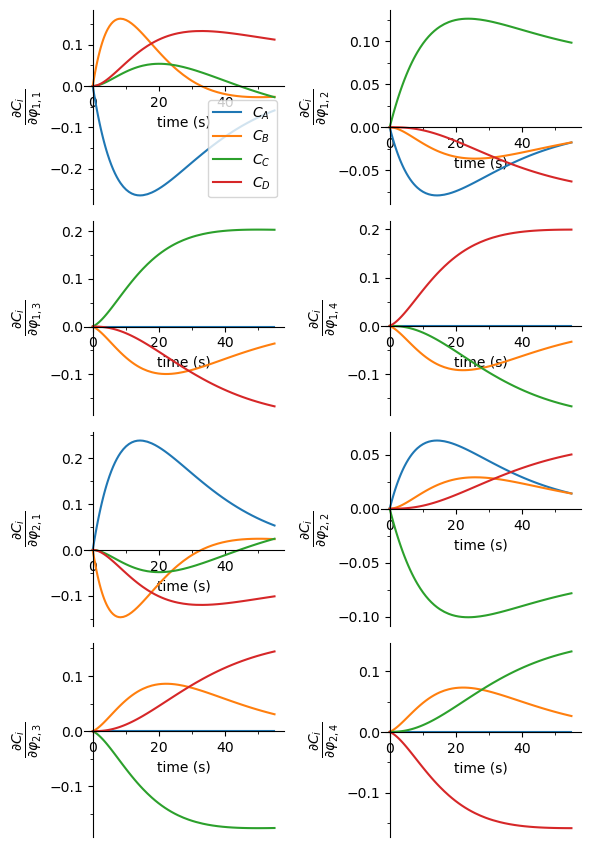

In [20]:
reactor.plot_sens(fig_size=(7, 7))

Final fit and correlatiobnb can be analyzed at the converged parameter values by using the `ParamInst` attribute of the simulation object

(<Figure size 640x480 with 2 Axes>, <AxesSubplot: >)

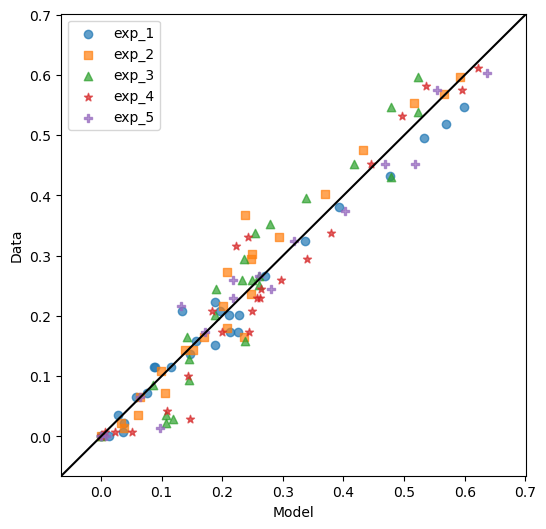

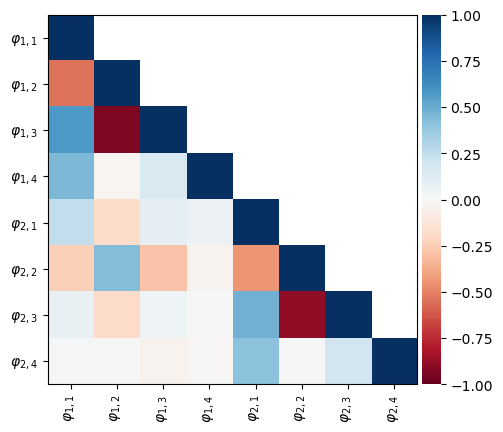

In [21]:
# Use the ParamInst object to analyze results
sim.ParamInst.plot_parity(fig_size=(6, 6))
sim.ParamInst.plot_correlation()

Finally, optimum parameters can be compiled in a pandas dataframe

In [22]:
optim_df = pd.DataFrame(np.column_stack((np.log(k_optim), ea_optim/8.314)), columns=('ln(A_optim)', 'ea_optim/R'), index=rxns)
print(optim_df)

         ln(A_optim)    ea_optim/R
A --> B    23.097013  18160.898475
A --> C    18.960181  16116.934841
B --> C    22.041934  17492.374021
B --> D    19.885501  16041.054422
